# Supervised learning project: predicting Boston housing prices

This project was completed as part of Udacity's Machine Learning Nanodegree.

In this project, we will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.


In [29]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import visuals as vs # Supplementary code
from sklearn.cross_validation import ShuffleSplit

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')

## Data Exploration
In this first section of this project, we will make a cursory investigation about the Boston housing data and provide our observations. Familiarizing ourselves with the data through an explorative process is a fundamental practice to help us better understand and justify our results.

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

In [30]:
# Features and prices are separated into different dataframes
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


### Implementation: Calculate Statistics
We will calculate descriptive statistics about the Boston housing prices. These statistics will be extremely important later on to analyze various prediction results from the constructed model.

In the code cell below, we will implement the following:
- Calculate the minimum, maximum, mean, median, and standard deviation of `'MEDV'`, which is stored in `prices`.
  - Store each calculation in their respective variable.

In [3]:
min_price= np.min(prices)
max_price= np.max(prices)
mean_price= np.mean(prices)
median_price= np.median(prices)
std_price= np.std(prices)

print("Statistics for Boston housing dataset:")
print("Minimum price: ${:,.2f}".format(min_price))
print("Maximum price: ${:,.2f}".format(max_price))
print("Mean price: ${:,.2f}".format(mean_price))
print("Median price: ${:,.2f}".format(median_price))
print("Standard deviation of prices: ${:,.2f}".format(std_price))

Statistics for Boston housing dataset:
Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price: $438,900.00
Standard deviation of prices: $165,171.13


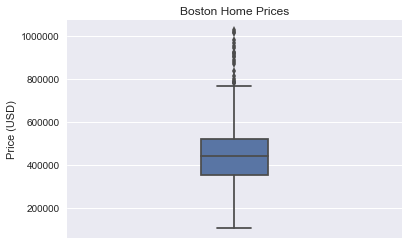

In [28]:
# Boxplot of prices to get a sense of the data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

ax= sns.boxplot(y=prices, width=0.2)
ax.set(title="Boston Home Prices", ylabel="Price (USD)")
plt.show()

### Question 1 - Feature Observation
As a reminder, we are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.

_Using your intuition, for each of the three features above, do you think that an increase in the value of that feature would lead to an **increase** in the value of `'MEDV'` or a **decrease** in the value of `'MEDV'`? Justify your answer for each._  
**Hint:** Would you expect a home that has an `'RM'` value of 6 be worth more or less than a home that has an `'RM'` value of 7?

**Answer**:
- **'RM'**: An increase in the number of rooms should lead to an increase in the house price. Indeed, a home with more rooms is usually more expensive.
- **'LSTAT'**: A large 'LSTAT' value means that more people who are considered "lower class" can afford to buy a home in this neighbourhood. Prices are likely to go down with an increase in the value of this feature.
- **'PTRATIO'**: In privileged areas, the number of students per teacher is typically kept low. An increase in 'PTRATIO' means that there are more students per teacher. Therefore, I expect an increase in this feature to have a negative impact on the value of 'MEDV'.

Let's see if our intuition is correct with scatterplots using Seaborn.

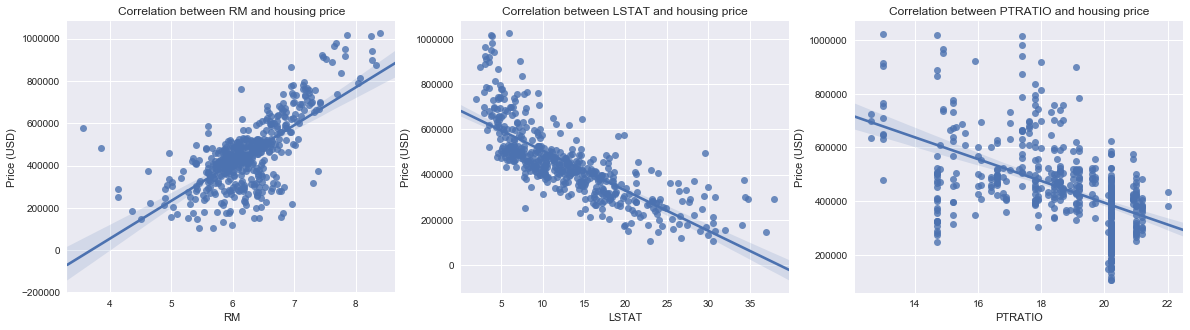

In [6]:
plt.figure(figsize=(20, 5))
for i,var in enumerate(features.columns):
    plt.subplot(1,3,i+1)
    sns.regplot(features[var],prices)
    sns.set()
    plt.title('Correlation between {} and housing price'.format(var))
    plt.ylabel("Price (USD)")

The scatterplots above support our answer.

----

## Developing a Model
In this second section of the project, you will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in your predictions.

### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, you will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify your model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 always fails to predict the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. *A model can be given a negative R<sup>2</sup> as well, which indicates that the model is no better than one that naively predicts the mean of the target variable.*

For the `performance_metric` function in the code cell below, you will need to implement the following:
- Use `r2_score` from `sklearn.metrics` to perform a performance calculation between `y_true` and `y_predict`.
- Assign the performance score to the `score` variable.

In [8]:
# TODO: Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Question 2 - Goodness of Fit
Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |
*Would you consider this model to have successfully captured the variation of the target variable? Why or why not?* 

Run the code cell below to use the `performance_metric` function and calculate this model's coefficient of determination.

In [8]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.923.


**Answer**: Yes, I would consider that this model has successfully captured the variation of the target variable. First, just by looking at the table, we can tell that the difference between the predictions and the true values is quite small. 
Our intuition is confirmed by the R^2 of this model: it is 0.923 (the best possible score being 1), confirming that this model makes reliable predictions because it captures 92.3% of the variation in the target variable.

### Implementation: Shuffle and Split Data
Your next implementation requires that you take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

For the code cell below, you will need to implement the following:
- Use `train_test_split` from `sklearn.cross_validation` to shuffle and split the `features` and `prices` data into training and testing sets.
  - Split the data into 80% training and 20% testing.
  - Set the `random_state` for `train_test_split` to a value of your choice. This ensures results are consistent.
- Assign the train and testing splits to `X_train`, `X_test`, `y_train`, and `y_test`.

In [9]:
# TODO: Import 'train_test_split'
from sklearn.cross_validation import train_test_split

# TODO: Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=7)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


In [10]:
print("Train shapes (X,y): ", X_train.shape, y_train.shape)
print("Test shapes (X,y): ", X_test.shape, y_test.shape)

Train shapes (X,y):  (391, 3) (391,)
Test shapes (X,y):  (98, 3) (98,)


### Question 3 - Training and Testing
*What is the benefit to splitting a dataset into some ratio of training and testing subsets for a learning algorithm?*  
**Hint:** What could go wrong with not having a way to test your model?

**Answer**: The benefit to splitting the dataset into training and testing subsets has to do with the evaluation of the algorithm. If we train our model using the entire dataset, we don't have any unseen data points left to test it. Having a test set lets us evaluate how well our model generalises to new data.

----

## Analyzing Model Performance
In this third section of the project, you'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, you'll investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing your model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

Run the code cell below and use these graphs to answer the following question.

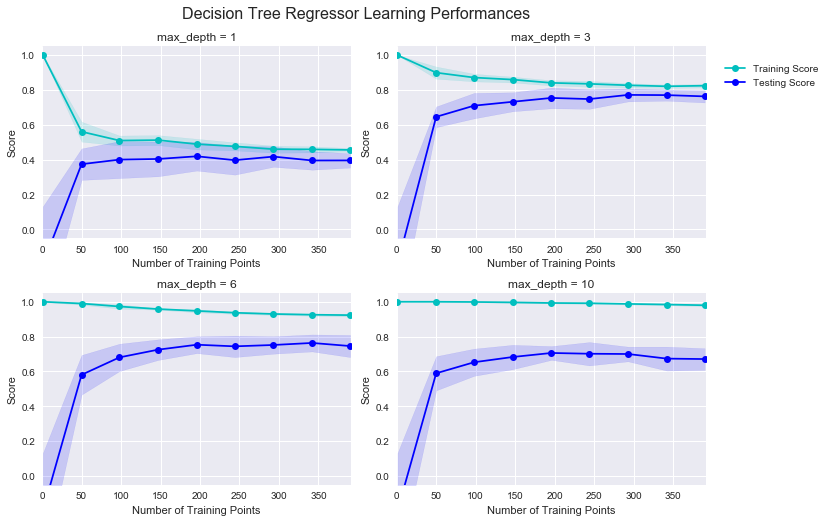

In [11]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Question 4 - Learning the Data
*Choose one of the graphs above and state the maximum depth for the model. What happens to the score of the training curve as more training points are added? What about the testing curve? Would having more training points benefit the model?*  
**Hint:** Are the learning curves converging to particular scores?

**Answer**: A good model has similar training and testing scores, both being high. The best performance is represented on the top right graph (max_depth=3), because the training and testing scores are both in the region of 0.8. We can also tell that the performance doesn't improve very much after 300 training points. 

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

Run the code cell below and use this graph to answer the following two questions.

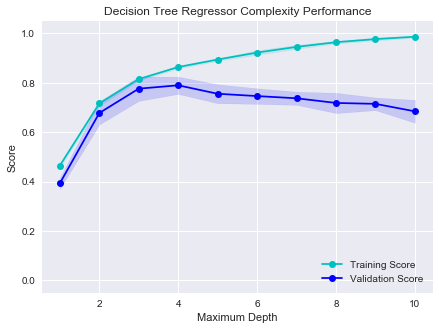

In [12]:
vs.ModelComplexity(X_train, y_train)

### Question 5 - Bias-Variance Tradeoff
*When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? What visual cues in the graph justify your conclusions?*  
**Hint:** How do you know when a model is suffering from high bias or high variance?

**Answer**: A model suffering from high bias typically has a low r^2. It is an oversimplified model that does not fit the training data well (and would not benefit from more training examples). On the contrary, a model with high variance overfits: it has a high r^2 on the training set and a lower r^2 on the validation set, meaning that it doesn't generalise well.
On the graph above, we can tell that the model suffers from high bias when it is trained with max_depth=1. The r^2 score is similarly low for the training and validation sets. When the model is trained with a maximum depth of 10, the curves are diverging: the r^2 score of the training set is close to 1 whereas the validation set does much worse (r^2 score around 0.7). At maximum depth 10, the model is very much overfitting.

### Question 6 - Best-Guess Optimal Model
*Which maximum depth do you think results in a model that best generalizes to unseen data? What intuition lead you to this answer?*

**Answer**: According to the graph above, the maximum depth that generalises best to unseen data is max_depth=3. This is because it corresponds to the highest r^2 score for both the training and the validation sets, before the curves start to diverge.

-----

## Evaluating Model Performance
In this final section of the project, you will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Question 7 - Grid Search
*What is the grid search technique and how it can be applied to optimize a learning algorithm?*

**Answer**: The grid search technique is a very convenient way to test different parameters, or different combinations of parameters, in order to fine-tune our algorithm. It returns the best parameters based on an evaluation metric of our choice, for example the r^2 score.

### Question 8 - Cross-Validation
*What is the k-fold cross-validation training technique? What benefit does this technique provide for grid search when optimizing a model?*  
**Hint:** Much like the reasoning behind having a testing set, what could go wrong with using grid search without a cross-validated set?

**Answer**: The K-fold cross-validation training technique is the partitioning of the dataset into K subsets of the same size in order to improve the training of our model. For example, with K=5, we would train our model using subsets 1-4 and test it with subset 5. We would then start over and train our model using subsets 2-5 and test it with subset 1 etc. Ultimately, we'll have run K different learning experiments, each time training on K-1 subsets and keeping one for testing. We then average the testing set performances from those K experiments. 
When combined with K-fold cross-validation training, the grid search technique gives us an even better fit since it has effectively made use of all the data points that we had. Using different test sets ensures that the model will generalise well to unseen data. 

### Implementation: Fitting a Model
Your final implementation requires that you bring everything together and train a model using the **decision tree algorithm**. To ensure that you are producing an optimized model, you will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

For the `fit_model` function in the code cell below, you will need to implement the following:
- Use [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) from `sklearn.tree` to create a decision tree regressor object.
  - Assign this object to the `'regressor'` variable.
- Create a dictionary for `'max_depth'` with the values from 1 to 10, and assign this to the `'params'` variable.
- Use [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) from `sklearn.metrics` to create a scoring function object.
  - Pass the `performance_metric` function as a parameter to the object.
  - Assign this scoring function to the `'scoring_fnc'` variable.
- Use [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) from `sklearn.grid_search` to create a grid search object.
  - Pass the variables `'regressor'`, `'params'`, `'scoring_fnc'`, and `'cv_sets'` as parameters to the object. 
  - Assign the `GridSearchCV` object to the `'grid'` variable.

In [14]:
# TODO: Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # TODO: Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # TODO: Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':list(range(1,11))}

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # TODO: Create the grid search object
    grid = GridSearchCV(regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. You can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

### Question 9 - Optimal Model
_What maximum depth does the optimal model have? How does this result compare to your guess in **Question 6**?_  

Run the code block below to fit the decision tree regressor to the training data and produce an optimal model.

In [15]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 4 for the optimal model.


**Answer**: The optimal model has a maximum depth of 4, which is not far from what I had guessed. However, I agree that at max_depth=4, the training and validation scores are both high and still similar enough.

### Question 10 - Predicting Selling Prices
Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |
*What price would you recommend each client sell his/her home at? Do these prices seem reasonable given the values for the respective features?*  
**Hint:** Use the statistics you calculated in the **Data Exploration** section to help justify your response.  

Run the code block below to have your optimized model make predictions for each client's home.

In [16]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3
client_prices = []
# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))
    client_prices.append(price)

Predicted selling price for Client 1's home: $407,232.00
Predicted selling price for Client 2's home: $229,200.00
Predicted selling price for Client 3's home: $979,300.00


**Answer**: These prices seem to be reasonable considering the average price of a home in Boston (mean price: \$454,342.94 and median price: \$438,900.00). They also are located between the minimum and maximum prices we had in the dataset (minimum price: \$105,000.00 and maximum price: \$1,024,800.00). 
The predictions are consistent with our intuition: the home of client 3 has many rooms and seems to be located in a privileged area (low 'poverty level' and low student-teacher ratio), which is consistent with a high price. On the other hand, the home of client 2 has less rooms and it is located in a neighbourhood where many 'lower class' people live and there are a lot of students per teacher. These clues point to the area being poorer than the ones where client 1 and 3 live. This is consistent with a lower estimate for that home.

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. Run the code cell below to run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with the data it's trained on.

In [17]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $424,935.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $413,334.78
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $73,357.39


### Question 11 - Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answer:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

**Answer**: Despite a good score, the ten trials above suggest that the current model should not be used today in Boston, because the range in prices is very high. The inconsistency observed in the predicted prices is very likely caused by:
- the features that we have used are not sufficient to describe a home. For instance, a house that needs a lot of work would probably be cheaper than one that is in perfect condition. Plus, the number of rooms is not always a good indicator of a home value: it would be very useful to have the square footage of the house as well.
- the dataset is from 1978 and, even though prices have been scaled, it is not enough to account for the changes that have occurred in the last 40 years, e.g. increasing population density. For example, in London, many houses have actually been divided into several small flats since 1978 in order to maximise rental income for landlords. In consequence, houses with more than 4 rooms are extremely rare, yet our model has been trained with data points corresponding to a now unrealistic number of rooms.

This model cannot be used for predicting prices in a rural city because, in general, prices vary enormously between cities and the coutryside, even for houses that would be comparable in terms of number of rooms etc. The model cannot be used for cities in other countries either because the average price of a home varies a lot between countries (compare Tokyo and Prague, for example).